# Spatial Target Cells

Analyses for if cells care about the spatial target.

Cells of interest:
- 74 looks to be a serial position cell

In [1]:
%config Completer.use_jedi = False

In [2]:
from collections import Counter

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import compute_spatial_bin_edges, compute_spatial_bin_assignment
from spiketools.plts.space import plot_space_heat
from spiketools.utils import restrict_range
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions

## Functions

In [5]:
# Note: copied from 01 - consolidate location
def compute_bin_firing(x_binl, y_binl, bins):
    """Compute firing per bin, givin bin assignment of each spike."""
    
    bin_firing = np.zeros(bins)
    for x_bl, y_bl in zip(x_binl, y_binl):
        bin_firing[x_bl - 1, y_bl - 1] += 1
        
    return bin_firing

## Settings

In [6]:
# Define binning for chests (spatial target)
chest_bins = [5, 7]

## Load Data

In [7]:
# Load NWB file
io = NWBHDF5IO('nwb_local_data.nwb', 'r')
nwbfile = io.read()

In [8]:
# Get the number of trials & units
n_trials = len(nwbfile.trials)
n_units = len(nwbfile.units)

In [9]:
# Get spikes
uind = 74
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

In [10]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [11]:
# Get the chest positions & trial indices
chest_xs, chest_ys  = nwbfile.acquisition['chest_positions']['chest_positions'].data[:]
chest_trials = nwbfile.acquisition['chest_trials']['chest_trials'].data[:]

## Chest Positions

In [12]:
# Check chest position range
print('Chest X position range: {:1.2f} - {:1.2f}'.format(np.min(chest_xs), np.max(chest_xs)))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(np.min(chest_ys), np.max(chest_ys)))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [13]:
# Check traversal position range
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[0, :]), np.max(positions[0, :])))
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[1, :]), np.max(positions[1, :])))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


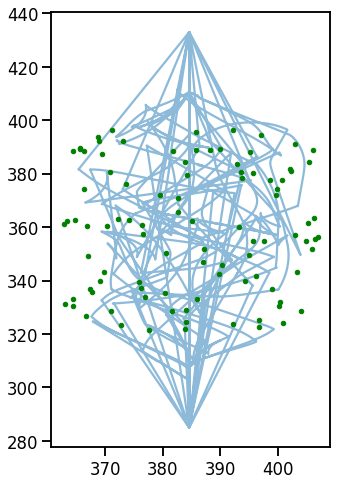

In [14]:
# Plot the chest positions, overlaid with 
#   Note: update this to use plot_positions
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*positions, alpha=0.5)
ax.plot(chest_xs, chest_ys, '.g');

In [15]:
# Compute edges for chest binning
area_range = [[360, 410], [320, 400]]
x_edges, y_edges = compute_spatial_bin_edges(positions, chest_bins, area_range=area_range)

In [16]:
# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_spatial_bin_assignment(chest_pos, x_edges, y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1 
ch_ybin = ch_ybin - 1 

## Single Trial

In [17]:
# Get trial information
t_ind = 10
t_st = nwbfile.trials['start_time'][t_ind]
# HACK start time (TO-FIX)
t_st = t_st-15000
ch_openings = nwbfile.trials['chest_opening'][t_ind]
t_en = ch_openings[-1]

In [18]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [19]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [20]:
# Restrict spikes to the 
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

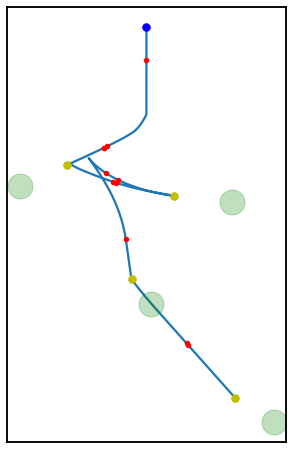

In [21]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
# TODO: add stimulus and event happenings to `plot_positions` & use that here
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*t_pos)
ax.plot(*t_pos[:, 0], 'b.', ms=15)
ax.plot(t_spike_xs, t_spike_ys, '.r')
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

## Serial Position

In [22]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [23]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
inds = count.keys()
frs = np.array(list(count.values())) / seg_times * 1000

<BarContainer object of 4 artists>

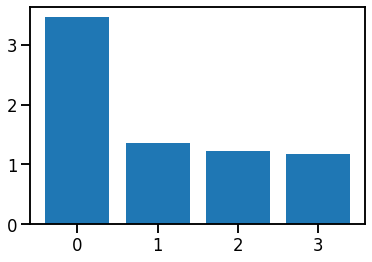

In [24]:
# Plot firing rate per segment (single trial)
plt.bar(inds, frs)

In [25]:
# Collect firing rates per segment across all trials
all_frs = np.zeros([n_trials, 4])
for t_ind in range(n_trials):
    
    t_st = nwbfile.trials['start_time'][t_ind]
    t_st = t_st-15000
    ch_openings = nwbfile.trials['chest_opening'][t_ind]
    t_en = ch_openings[-1]
    
    t_mask = chest_trials == t_ind
    
    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
    ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]
    
    t_spikes = restrict_range(spikes, t_st, t_en)
    
    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))
    inds = count.keys()
    frs = np.array(list(count.values())) / seg_times * 1000
    
    all_frs[t_ind, :] = frs

<BarContainer object of 4 artists>

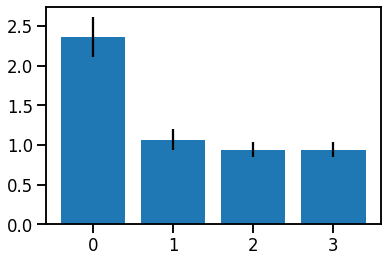

In [26]:
# Plot firing rates per segment across all trials
plt.bar(inds, all_frs.mean(0), yerr=sem(all_frs, 0))

## Spatial Target Bins

In [27]:
# Compute chest occupancy
chest_occupancy = compute_bin_firing(ch_xbin, ch_ybin, chest_bins)

In [28]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(\
    np.min(chest_occupancy), np.max(chest_occupancy)))

Range of chests per bin: 0 - 6


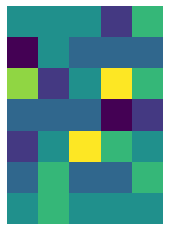

In [29]:
# Plot chest occupancy
plot_space_heat(chest_occupancy, transpose=True)

In [30]:
# Collect firing per chest location across all trials
target_bins = np.zeros(chest_bins)
for t_ind in range(n_trials):
    
    t_st = nwbfile.trials['start_time'][t_ind] - 15000
    ch_openings = nwbfile.trials['chest_opening'][t_ind]
    t_en = ch_openings[-1]
    
    t_mask = chest_trials == t_ind
    
    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
    ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]
    
    t_spikes = restrict_range(spikes, t_st, t_en)
    t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))
    
    frs = np.array(list(count.values())) / seg_times * 1000    
    
    cur_ch_xbin = ch_xbin[t_mask]
    cur_ch_ybin = ch_ybin[t_mask]

    for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
        target_bins[xbin, ybin] = fr

In [31]:
# Check range of firing across spatial target bins
np.min(target_bins), np.max(target_bins)

(0.0, 4.153647434329197)

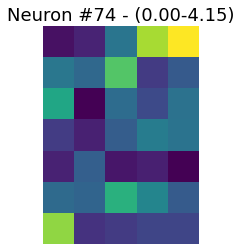

In [32]:
# Check the firing rate per spatial destination for an example neuron
plot_space_heat(target_bins, transpose=True,
                title='Neuron #{} - ({:1.2f}-{:1.2f})'.format(uind, np.min(target_bins), np.max(target_bins)))

## All Cells

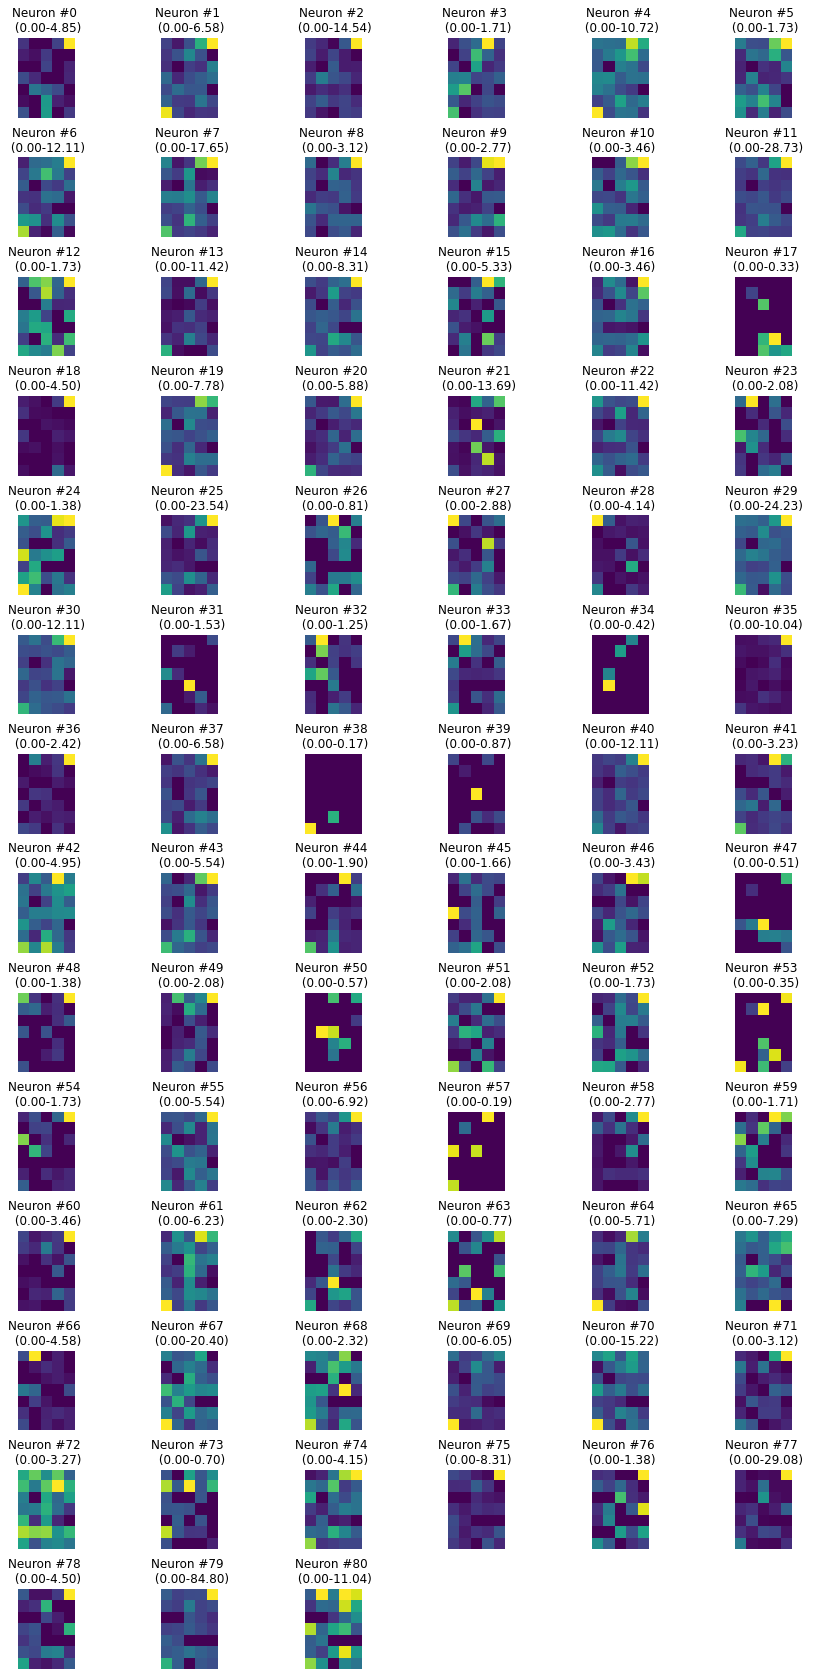

In [33]:
# Plot spatial target heat maps for all cells
_, axes = plt.subplots(14, 6, figsize=(15, 30))
for ii, ax in zip(range(0, n_units), axes.flatten()):
    
    spikes = nwbfile.units.get_unit_spike_times(ii) / 1000

    target_bins = np.zeros(chest_bins)
    for t_ind in range(n_trials):

        t_st = nwbfile.trials['start_time'][t_ind] - 15000
        ch_openings = nwbfile.trials['chest_opening'][t_ind]
        t_en = ch_openings[-1]

        t_mask = chest_trials == t_ind

        t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
        ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

        t_spikes = restrict_range(spikes, t_st, t_en)
        t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

        seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
        count.update(np.digitize(t_spikes, ch_openings))

        frs = np.array(list(count.values())) / seg_times * 1000    

        cur_ch_xbin = ch_xbin[t_mask]
        cur_ch_ybin = ch_ybin[t_mask]

        for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
            target_bins[xbin, ybin] = fr

    plot_space_heat(target_bins, transpose=True, ax=ax)   
    ax.set_title('Neuron #{} \n ({:1.2f}-{:1.2f})'.format(ii, np.min(target_bins), np.max(target_bins)), 
                 fontdict={'fontsize' : 12});
    
plt.subplots_adjust(hspace=0.5)
for ii in range(n_units, len(axes.flatten())):
    axes.flatten()[ii].set_axis_off()